In [9]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.9 MB/s 


In [11]:
import pandas as pd
import os
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
from getpass import getpass
import plotly.figure_factory as ff
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'colab'
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px


###Imbalanced datasets
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks


###models------
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, roc_auc_score, classification_report, f1_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate

#---------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier


#Configurations

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 400
ruta = "/content/drive/MyDrive/prueba_addi/"
plt.figure(figsize=(25,10))

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

## Data Description

>  This research aimed at the case of customers default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel sorting Smoothing Method to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X).



>**Variables:**

>*LIMIT_BAL*: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
>SEX: Gender (1 = male; 2 = female).

>*EDUCATION*: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

>*MARRIAGE*: Marital status (1 = married; 2 = single; 3 = divorse, 0= others).

>*AGE*: Age (year).

>*PAY0 - PAY6*: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: PAY0 = the repayment status in September, 2005; PAY1 = the repayment status in August, 2005; . . .;PAY6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

>*BILL_AMT1- BILL_AMT6*: Amount of bill statement (NT dollar). BILL_AMT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; . . .; BILL_AMT6 = amount of bill statement in April, 2005.

>*PAY_AMT1-PAY_AMT2*: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; . . .; PAY_AMNT6 = amount paid in April, 2005.





**Load Data**

In [12]:
df = pd.read_excel("/content/drive/MyDrive/prueba_addi/df_ADDI.xls", sheet_name="Data", skiprows=1)

## General Functions

In [13]:
def trend(x, y, s="up"):

  """ This functions help us to calculate trends in each variable,
   we cam follow if the variable go up or down

  Input:
      x (float): lag_n for each variable
      y (float): lag_n+1 for each variable
  Output:
      x-y or 0 (float) regarding the conditions
  """

  if s=="up":

    if (x-y>=0):

      return x-y

    else:

      return 0
  else:
    if (x-y<0):

      return x-y

    else:

      return 0


#------------------------------------------------------------------------------

def make_mi_scores(X, y, discrete_features=None):

    """ Function to calculate the entropy of each variable throught mutual
     information score.

    Inpus X (num): (Covariables)
    Output mic (float)"""

    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.DataFrame(mi_scores, index=X.columns, columns=["MIC"])
    mi_scores = mi_scores.sort_values(by="MIC",ascending=False)

    return mi_scores


#------------------------------------------------------------------------------


def select_k_variables(mi_scores_1, X_train, y_train, X_test, y_test, solver, penalty, C, class_weight):

      """ This function runs a simple Logistic regresion for select the
       most importance variables regarding to AUC score.

      Input:
            mi_scores_1 (df): Dataframe with MIC
            X (df): Covariates
            y (df): Target variables, this is binary
            solver (str): solver for LGR
            penalty (str): type of penalty of LGR
            C (float): for penalty
            class_weight (str)

      Output:
            scores (List): result of AUC for each simple model

      """

      scores = []
      importance = list(mi_scores_1.sort_values(by="MIC", ascending=True).index)
      y_train = y_train.values
      y_test = y_test.values

      for feat in importance[0:-1]:

          X_train= X_train.drop(str(feat), axis=1)
          X_test = X_test.drop(str(feat), axis=1)

          X_train_ = X_train.values

          X_test_ = X_test.values
      

          lr = LogisticRegression(solver=solver, C=C, penalty=penalty,
                                  class_weight=class_weight)
          lr.fit(X_train, y_train)
          proba = lr.predict_proba(X_test)
          scores.append(roc_auc_score(y_test, proba[:,1]))

      return scores, importance


#------------------------------------------------------------------------------

def train_baseline_models( models, X_train, y_train, n_splits_=10, n_rep=5):

    """ This function help us to train baseline models and perform kfold validation
    for select the best model
    INPUTS:
      models : Basellines models to train
      X_train (df): Covariates
      y_train (df): Target variable
      n_splits (int): number of splits for Kfold
      n_rep (int): number of repetitions

    OUTPUTS:

    f1_scores (dict): values of f1 score
    acuraccy_scores (dict): values of acuraccy score
    auc_scores (dict): values of auc score
    models_fit (dict): models
    """

    f1_scores = {}
    acuraccy_scores = {}
    auc_scores = {}
    models_fit = {}

    rkf = RepeatedKFold(n_splits=n_splits_, n_repeats=n_rep, random_state=1)

    for i,model in enumerate(models):

      for train_idx, test_idx in rkf.split(X_train, y_train):

            x_train, x_test = X_train[train_idx], X_train[test_idx]
            y_train, y_test = y_train[train_idx], y_train[test_idx]
        
            model.fit(x_train, y_train)

            models_fit[models_text[i]]= model

            proba = model.predict_proba(x_test)

            proba_bin = model.predict(x_test)

            auc_scores[models_text[i]] = roc_auc_score(y_test, proba[:,1])

            f1_scores[models_text[i]] = f1_score(y_test, proba_bin)

            acuraccy_scores[models_text[i]] = accuracy_score(y_test, proba_bin)

      return f1_scores, acuraccy_scores,  auc_scores,  models_fit 

## EDA

In [ ]:
print("The dimension of this Dataset is:", df.shape)

The dimension of this Dataset is: (30000, 25)


In [ ]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000



* The mean for our target variable is 0.221, which means that there are 22.1% of credit card that will default next month.

* The average value for the amount of credit card limit is 167,484.32
We have that the standard deviation is 129,747.6 (**Is very Large**).


* Regarding Eduaction level we have that the mean is 1.85 with standard deviation 0.79, so almost all the clients have university or graduate school in their education.

* The average age is 35.5 years, with a standard deviation of 9.2.


**Exploring null values**

<Figure size 1800x720 with 0 Axes>

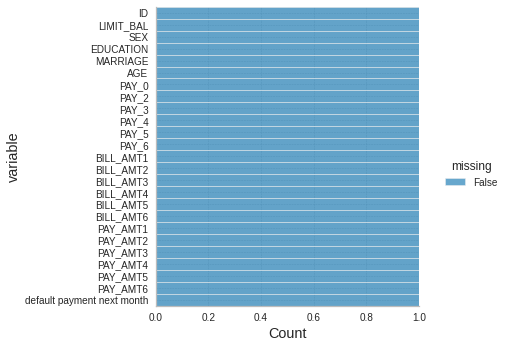

In [98]:
plt.figure(figsize=(25,10))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)


plt.savefig(ruta+"/plots/missing_data.png", dpi=100)
plt.show()



**Exploring categorical features**

In [ ]:
var_cats = ["SEX", 	"EDUCATION",	"MARRIAGE",	"AGE", "default payment next month"]

for var in var_cats:
  df_aux= df.groupby(var).agg({"ID":"count"}).rename(columns={"ID":"Count"}).reset_index()
  fig = px.bar(df_aux, x=var, y="Count", title = "Basic analysis of:"+" "+ var)
  fig.update_layout(template='seaborn')
  fig.update_traces(marker_color="cadetblue", marker_line_color='rgb(8,48,107)', marker_line_width=0.3, opacity=0.5)
  plotly.offline.plot(fig, filename = ruta+"/plots/exploracion_cat_basic_"+var+".html", auto_open=False)
  fig.show(renderer="colab")


**WE HAVE A IMBALANCED DATASET, WE NEED TO FIX IT**

In [14]:
df["EDUCATION"] = df["EDUCATION"].apply(lambda x: 0 if ((x!=1) & (x!=2) & (x!=3) & (x!=4)) else x )
df["MARRIAGE"] = df["MARRIAGE"].apply(lambda x: 0 if ((x!=1) & (x!=2) & (x!=3)) else x )

bins = [20,30, 40, 52,  72, 91] #bin for each generation
df["AGE_GROUP"] = pd.cut(df['AGE'], bins=bins)
df.AGE_GROUP = df.AGE_GROUP.astype(str)

print(df.AGE_GROUP.value_counts())
#df.drop("AGE", inplace=True, axis=1)

(20, 30]    11013
(30, 40]    10713
(40, 52]     6649
(52, 72]     1616
(72, 91]        9
Name: AGE_GROUP, dtype: int64


In [ ]:
limit_bal = df["LIMIT_BAL"].values.tolist()
education = list(df.EDUCATION.unique())

education_limit = {}

for edu in education:

  education_limit[edu] = df["LIMIT_BAL"].loc[df['EDUCATION'] == edu].values.tolist()


trace0 = go.Histogram(
    x=education_limit[0],
    histnorm='probability',
    name="Education: N/A",
    marker = dict(color = 'rgba(100, 149, 237, 0.6)',)
)
trace1 = go.Histogram(
    x= education_limit[0],
    histnorm='probability',
    name="Education: Graduate school",
    marker = dict(
        color = 'rgba(255, 182, 193, 0.6)',
    )
)
trace2 = go.Histogram(
    x=education_limit[2],
    histnorm='probability',
    name="Education: University",
     marker = dict(
        color = 'rgba(169, 169, 169, 0.6)',
    )
)

trace3 = go.Histogram(
    x=education_limit[3],
    histnorm='probability',
    name="Education: High school",
     marker = dict(
        color = 'rgba(222,184,135, 0.6)',
    )
)

trace4 = go.Histogram(
    x=education_limit[4],
    histnorm='probability',
    name="Education: Others",
     marker = dict(
        color = 'rgba(143,188,143,0.6)',
    )
)


trace5 = go.Histogram(
    x= limit_bal,
    histnorm='probability',
    name="Education: All",
    marker = dict(
    color = 'rgba(48,48,48, 0.6)',
    )
)


fig = tools.make_subplots(rows=3, cols=3,  specs= [[{}, {}, {}],[{ "rowspan": 1,"colspan": 2},{}, {}], [{"rowspan": 1, "colspan": 3}, None, None]],
                          subplot_titles=('N/A','Graduate School', 'University', "High School", " ", "Others", "All"))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 3)
fig.append_trace(trace5, 3, 1)

fig.update_layout(template='seaborn')
fig['layout'].update(showlegend=True, title='Amount of the given credit per education', bargap=0.05)
iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

plotly.offline.plot(fig, filename = ruta+"/plots/bill_amount_edu.html", auto_open=False)


/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



'/content/drive/MyDrive/prueba_addi//plots/bill_amount_edu.html'

In [6]:
df['limit_bins'] = pd.cut(df['LIMIT_BAL'],[5000, 50000, 100000, 150000, 200000, 300000, 400000, 500000, 1100000])


df['limit_bins'] = df['limit_bins'].astype('str')
limit_bin_order = ['(5000, 50000]', '(50000, 100000]', '(100000, 150000]', '(150000, 200000]',
                '(200000, 300000]', '(300000, 400000]', '(400000, 500000]', '(500000, 1100000]']

a =df.groupby(["limit_bins", "default payment next month"]).agg({"ID":"count"}).rename(columns={"ID":"Count"}).reset_index()
fig = px.bar(a, x="limit_bins",y="Count", color="default payment next month",color_discrete_sequence= px.colors.sequential.YlGn, category_orders= {"limit_bins":limit_bin_order},
            width=1250, height=400, title= "Amount of clients in each bin of limit credit")

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Bins of Amount of credit')


fig.update_traces( marker_line_color='rgb(8,48,107)', marker_line_width=0.5, opacity=0.5)
plotly.offline.plot(fig, filename = ruta+"/plots/bins_limit_default.html", auto_open=False)
fig.show(renderer="colab")


In [13]:
age_group_order = ["(20, 30]", "(30,40]", "(40,52]","(52,72]","(72,91]"]
fig = px.violin(df, y="LIMIT_BAL", x="AGE_GROUP", color="MARRIAGE", box=True, color_discrete_sequence=["cadetblue", "burlywood", "coral", "goldenrod"], 
                title="Distribution: Amount of the given credit per Age group",  )

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Age group (Generation)')
fig.update_yaxes(title_text= 'Limit Amount($)')
fig.update_traces( marker_line_color='rgb(8,48,107)', marker_line_width=0.3, opacity=0.75)
plotly.offline.plot(fig, filename = ruta+"/plots/bill_amount_age_marriage.html", auto_open=False)
fig.show(renderer="colab")

In [15]:
fig = px.violin(df, y="LIMIT_BAL", x="EDUCATION", color="default payment next month",facet_col="SEX", box=True, color_discrete_sequence=["cadetblue", "burlywood", "coral", "goldenrod"]
                ,title="Distribution: Amount of the given credit per default of payment",width=1100, facet_col_spacing=0 )
fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Education')
#fig.update_yaxes(title_text= 'Limit A($)',)
fig.update_traces( marker_line_color='rgb(8,48,107)', marker_line_width=0.3, opacity=0.75)
plotly.offline.plot(fig, filename = ruta+"/plots/bill_amount_default_educa_sex.html", auto_open=False)
fig.show(renderer="colab")


Exploration for our target variable: **Default payment next month**

In [16]:
a =df.groupby(["EDUCATION", "MARRIAGE","default payment next month"]).agg({"ID":"count"}).rename(columns={"ID":"Count"}).reset_index()
fig = px.bar(a, x="EDUCATION", y="Count", color="default payment next month",color_discrete_sequence= px.colors.sequential.YlGn,
            facet_col="MARRIAGE", width=1250, height=400, title="Default of payment for Eduaction and marital status")
fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Education')
fig.update_traces( marker_line_color='rgb(8,48,107)', marker_line_width=0.5, opacity=0.5)
plotly.offline.plot(fig, filename = ruta+"/plots/pay_defaults_marriage_edu.html", auto_open=False)
fig.show(renderer="colab")



In [18]:
a = pd.DataFrame(df['default payment next month'].groupby(df[ "AGE_GROUP"]).value_counts(normalize = True)).rename(columns={"default payment next month": "% of Default"}).reset_index()
a = a[a["default payment next month"]==1]

fig = px.bar(a, x="AGE_GROUP", y="% of Default", width=1250, height=400, title = "% of Default per Age group")

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Age Group')
fig.update_traces(marker_color="cadetblue", marker_line_color='rgb(8,48,107)', marker_line_width=0.3, opacity=0.5)
plotly.offline.plot(fig, filename = ruta+"/plots/pay_defaults_age_group.html", auto_open=False)
fig.show(renderer="colab")


Exploration for: **Repayments** \\
Remember:




2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

In [49]:
repays = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

figs = {}
dfs_aux = {}
for repay in repays:

  dfs_aux[repay] =df.groupby([repay,"default payment next month"]).agg({"ID":"count"}).rename(columns={"ID":"Count"}).reset_index()
  figs[repay] = px.bar(dfs_aux[repay], x=repay, y="Count", color="default payment next month",color_discrete_sequence= px.colors.sequential.YlGn,
              width=1250, height=400, title="Default for each Repayments in: "+ repay)
  figs[repay].update_layout(template='seaborn')
  figs[repay].update_xaxes(title_text=repay)
  figs[repay].update_traces( marker_line_color='rgb(8,48,107)', marker_line_width=0.5, opacity=0.5)
  plotly.offline.plot(figs[repay], filename = ruta+"/plots/default_"+repay+".html", auto_open=False)
  figs[repay].show(renderer="colab")


**Correlations**

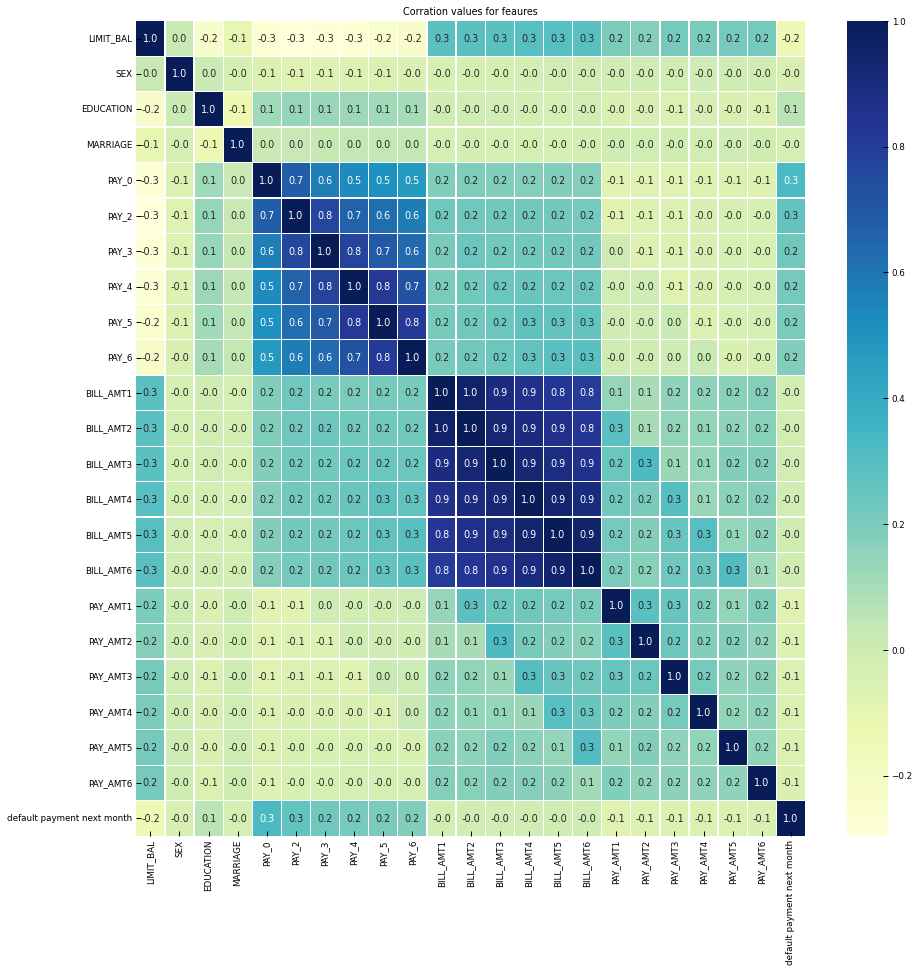

In [61]:
df.drop(["ID"], axis=1,inplace=True)
f = plt.figure(figsize= (15,15))
sns.set_context("paper", font_scale=1.)
sns.heatmap(df.corr(),  annot=True,  linewidths=.3, fmt= '.1f',cmap="YlGnBu")
plt.title("Corration values for feaures")
plt.savefig(ruta+"/plots/correlations.png", dpi=100); 

## Feature Engineering

In [15]:
var_trends = [ "BILL_AMT", "PAY_AMT"]

for var in var_trends:

    df[var+"_A_1"] = df.apply(lambda x: trend(x[var+"1"], x[var+"2"],s="up"), axis=1)
    df[var+"_A_2"] = df.apply(lambda x: trend(x[var+"2"], x[var+"3"], s="up"), axis=1)
    df[var+"_A_3"] = df.apply(lambda x: trend(x[var+"3"], x[var+"4"],s="up"), axis=1)
    df[var+"_A_4"] = df.apply(lambda x: trend(x[var+"4"], x[var+"5"],s="up"), axis=1)
    df[var+"_A_5"] = df.apply(lambda x: trend(x[var+"5"], x[var+"6"],s="up"), axis=1)

    df[var+"_B_1"] = df.apply(lambda x: trend(x[var+"1"], x[var+"2"],s="down"), axis=1)
    df[var+"_B_2"] = df.apply(lambda x: trend(x[var+"2"], x[var+"3"], s="down"), axis=1)
    df[var+"_B_3"] = df.apply(lambda x: trend(x[var+"3"], x[var+"4"],s="down"), axis=1)
    df[var+"_B_4"] = df.apply(lambda x: trend(x[var+"4"], x[var+"5"],s="down"), axis=1)
    df[var+"_B_5"] = df.apply(lambda x: trend(x[var+"5"], x[var+"6"],s="down"), axis=1)


In [16]:
df["PAY_AMT_LAST_3M"] =  df["PAY_AMT1"] + df["PAY_AMT2"] + df["PAY_AMT3"]
df["PAY_AMT_FIRTS_3M"] = df["PAY_AMT4"] +df["PAY_AMT5"]+df["PAY_AMT6"]
df["PAY_AMT_LAST_6M"] =  df["PAY_AMT1"] + df["PAY_AMT2"] + df["PAY_AMT3"] + df["PAY_AMT4"] +df["PAY_AMT5"]+df["PAY_AMT6"]
df["ratio_limit_pay"] =  df["LIMIT_BAL"]/(df["PAY_AMT_LAST_6M"]+1)

nums = [1,2,3,4,5]

for i in nums:

  df["BILL_AMT/PAY_AMT"+"_"+str(i)] = df["BILL_AMT"+str(i)]/(df["PAY_AMT"+str(i)]+1) 
  df["BILL_AMT_BIN_AT_"+str(i)] =  df["BILL_AMT_A_"+str(i)].apply(lambda x: 1 if x!=0 else 0)
  df["PAY_AMT_BIN_AT_"+str(i)] =  df["PAY_AMT_A_"+str(i)].apply(lambda x: 1 if x!=0 else 0)
  df["BILL_AMT_BIN_BT_"+str(i)] =  df["BILL_AMT_B_"+str(i)].apply(lambda x: 1 if x!=0 else 0)
  df["PAY_AMT_BIN_BT_"+str(i)] =  df["PAY_AMT_B_"+str(i)].apply(lambda x: 1 if x!=0 else 0)



df["BILL_AMT_AT"] = df["BILL_AMT_A_1"]+df["BILL_AMT_A_2"]+ df["BILL_AMT_A_3"]+df["BILL_AMT_A_4"]+df["BILL_AMT_A_5"] 

df["BILL_AMT_BT"] = df["BILL_AMT_B_1"]+df["BILL_AMT_B_2"]+ df["BILL_AMT_B_3"]+df["BILL_AMT_B_4"]+df["BILL_AMT_B_5"] 

df["PAY_AMT_AT"] = df["PAY_AMT_A_1"]+df["PAY_AMT_A_2"]+ df["PAY_AMT_A_3"]+df["PAY_AMT_A_4"]+df["PAY_AMT_A_5"] 

df["PAY_AMT_BT"] = df["PAY_AMT_B_1"]+df["PAY_AMT_B_2"]+ df["PAY_AMT_B_3"]+df["PAY_AMT_B_4"]+df["PAY_AMT_B_5"] 

#-----------------------------------------Trends bin

df["BILL_AMT_BIN_AT_2"] =df["BILL_AMT_BIN_AT_1"] +df["BILL_AMT_BIN_AT_2"]
df["BILL_AMT_BIN_AT_3"] =df["BILL_AMT_BIN_AT_1"] +df["BILL_AMT_BIN_AT_2"]+df["BILL_AMT_BIN_AT_3"]
df["BILL_AMT_BIN_AT_4"] =df["BILL_AMT_BIN_AT_1"] +df["BILL_AMT_BIN_AT_2"]+df["BILL_AMT_BIN_AT_3"]+df["BILL_AMT_BIN_AT_4"]
df["BILL_AMT_BIN_AT_5"] =df["BILL_AMT_BIN_AT_1"] +df["BILL_AMT_BIN_AT_2"]+df["BILL_AMT_BIN_AT_3"]+df["BILL_AMT_BIN_AT_4"]+df["BILL_AMT_BIN_AT_5"]


df["PAY_AMT_BIN_AT_2"] =df["PAY_AMT_BIN_AT_1"] +df["PAY_AMT_BIN_AT_2"]
df["PAY_AMT_BIN_AT_3"] =df["PAY_AMT_BIN_AT_1"] +df["PAY_AMT_BIN_AT_2"]+df["PAY_AMT_BIN_AT_3"]
df["PAY_AMT_BIN_AT_4"] =df["PAY_AMT_BIN_AT_1"] +df["PAY_AMT_BIN_AT_2"]+df["PAY_AMT_BIN_AT_3"]+df["PAY_AMT_BIN_AT_4"]
df["PAY_AMT_BIN_AT_5"] =df["PAY_AMT_BIN_AT_1"] +df["PAY_AMT_BIN_AT_2"]+df["PAY_AMT_BIN_AT_3"]+df["PAY_AMT_BIN_AT_4"]+df["PAY_AMT_BIN_AT_5"]


df["BILL_AMT_BIN_BT_2"] =df["BILL_AMT_BIN_BT_1"] +df["BILL_AMT_BIN_BT_2"]
df["BILL_AMT_BIN_BT_3"] =df["BILL_AMT_BIN_BT_1"] +df["BILL_AMT_BIN_BT_2"]+df["BILL_AMT_BIN_BT_3"]
df["BILL_AMT_BIN_BT_4"] =df["BILL_AMT_BIN_BT_1"] +df["BILL_AMT_BIN_BT_2"]+df["BILL_AMT_BIN_BT_3"]+df["BILL_AMT_BIN_BT_4"]
df["BILL_AMT_BIN_BT_5"] =df["BILL_AMT_BIN_BT_1"] +df["BILL_AMT_BIN_BT_2"]+df["BILL_AMT_BIN_BT_3"]+df["BILL_AMT_BIN_BT_4"]+df["BILL_AMT_BIN_AT_5"]


df["PAY_AMT_BIN_BT_2"] =df["PAY_AMT_BIN_BT_1"] +df["PAY_AMT_BIN_BT_2"]
df["PAY_AMT_BIN_BT_3"] =df["PAY_AMT_BIN_BT_1"] +df["PAY_AMT_BIN_BT_2"]+df["PAY_AMT_BIN_BT_3"]
df["PAY_AMT_BIN_BT_4"] =df["PAY_AMT_BIN_BT_1"] +df["PAY_AMT_BIN_BT_2"]+df["PAY_AMT_BIN_BT_3"]+df["PAY_AMT_BIN_BT_4"]
df["PAY_AMT_BIN_BT_5"] =df["PAY_AMT_BIN_BT_1"] +df["PAY_AMT_BIN_BT_2"]+df["PAY_AMT_BIN_BT_3"]+df["PAY_AMT_BIN_BT_4"]+df["PAY_AMT_BIN_BT_5"]



df["ratio_bill_pay_bin_AT"] = df["BILL_AMT_BIN_AT_5"]/(df["PAY_AMT_BIN_AT_5"]+1) 

df["ratio_bill_pay_bin_BT"] = df["BILL_AMT_BIN_BT_5"]/(df["PAY_AMT_BIN_BT_5"]+1) 


#-------------------------------------------------------------Basic Statistics variables--------------------------------------------------------

df["PAY_AMT_STD"] = df[["PAY_AMT1",	"PAY_AMT2",	"PAY_AMT3",	"PAY_AMT4",	"PAY_AMT5",	"PAY_AMT6"]].std(axis=1)
df["BILL_AMT_STD"] = df[["BILL_AMT1",	"BILL_AMT2",	"BILL_AMT3",	"BILL_AMT4",	"BILL_AMT5",	"BILL_AMT6"]].std(axis=1)

df["BILL_AMT_MAX"] = df[["BILL_AMT1",	"BILL_AMT2",	"BILL_AMT3",	"BILL_AMT4",	"BILL_AMT5",	"BILL_AMT6"]].max(axis=1)
df["PAY_AMT_MAX"] = df[["PAY_AMT1",	"PAY_AMT2",	"PAY_AMT3",	"PAY_AMT4",	"PAY_AMT5",	"PAY_AMT6"]].max(axis=1)
df["REPAYS_MEAN"] = df[["PAY_0",	"PAY_2",	"PAY_3",	"PAY_4",	"PAY_5",	"PAY_6"]].mean(axis=1)


df = pd.get_dummies(df, drop_first=True)
df.drop(["ID"], axis=1, inplace=True)

In [17]:
sc = StandardScaler()
df_prep = pd.DataFrame(sc.fit_transform(df.drop("default payment next month", axis=1)), columns=df.drop("default payment next month",axis=1).columns)
df_prep = pd.concat([df_prep, df[["default payment next month"]]], axis=1)

In [19]:
df_prep.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT_A_1,BILL_AMT_A_2,BILL_AMT_A_3,BILL_AMT_A_4,BILL_AMT_A_5,BILL_AMT_B_1,BILL_AMT_B_2,BILL_AMT_B_3,BILL_AMT_B_4,BILL_AMT_B_5,PAY_AMT_A_1,PAY_AMT_A_2,PAY_AMT_A_3,PAY_AMT_A_4,PAY_AMT_A_5,PAY_AMT_B_1,PAY_AMT_B_2,PAY_AMT_B_3,PAY_AMT_B_4,PAY_AMT_B_5,PAY_AMT_LAST_3M,PAY_AMT_FIRTS_3M,PAY_AMT_LAST_6M,ratio_limit_pay,BILL_AMT/PAY_AMT_1,BILL_AMT_BIN_AT_1,PAY_AMT_BIN_AT_1,BILL_AMT_BIN_BT_1,PAY_AMT_BIN_BT_1,BILL_AMT/PAY_AMT_2,BILL_AMT_BIN_AT_2,PAY_AMT_BIN_AT_2,BILL_AMT_BIN_BT_2,PAY_AMT_BIN_BT_2,BILL_AMT/PAY_AMT_3,BILL_AMT_BIN_AT_3,PAY_AMT_BIN_AT_3,BILL_AMT_BIN_BT_3,PAY_AMT_BIN_BT_3,BILL_AMT/PAY_AMT_4,BILL_AMT_BIN_AT_4,PAY_AMT_BIN_AT_4,BILL_AMT_BIN_BT_4,PAY_AMT_BIN_BT_4,BILL_AMT/PAY_AMT_5,BILL_AMT_BIN_AT_5,PAY_AMT_BIN_AT_5,BILL_AMT_BIN_BT_5,PAY_AMT_BIN_BT_5,BILL_AMT_AT,BILL_AMT_BT,PAY_AMT_AT,PAY_AMT_BT,ratio_bill_pay_bin_AT,ratio_bill_pay_bin_BT,PAY_AMT_STD,BILL_AMT_STD,BILL_AMT_MAX,PAY_AMT_MAX,REPAYS_MEAN,"AGE_GROUP_(30, 40]","AGE_GROUP_(40, 52]","AGE_GROUP_(52, 72]","AGE_GROUP_(72, 91]",default payment next month
0,-1.136720,0.810161,0.277857,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,-0.223991,-0.157329,-0.256409,-0.310955,-0.258620,0.219283,0.164479,0.189034,0.196150,0.200910,-0.198956,-0.127630,-0.187219,-0.180383,-0.184264,0.114890,0.170678,0.179048,0.184879,0.180668,-0.393459,-0.460288,-0.509027,-0.186593,0.005673,1.131976,-0.890971,-0.949031,1.226788,-0.165183,1.524561,0.053566,-1.238572,0.464412,-0.138785,1.659451,-0.745841,-1.331796,0.484430,-0.179567,1.331635,-0.735256,-1.373050,0.469636,-0.172766,1.353768,-0.745359,0.011938,0.482781,-0.467168,0.395133,-0.354026,0.336767,0.960190,-0.520062,-0.368090,-0.508140,-0.722665,-0.399632,-0.153635,-0.745286,-0.533612,-0.238607,-0.017323,1
1,-0.365981,0.810161,0.277857,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,-0.215884,-0.290974,-0.287716,-0.310955,-0.245684,0.219283,0.113500,0.145834,0.181417,0.200910,-0.198956,-0.161993,-0.187219,-0.110268,-0.184264,0.099100,0.170678,0.179048,0.184879,0.057524,-0.361463,-0.367244,-0.438153,-0.186697,-0.050213,1.131976,-0.890971,-0.949031,1.226788,-0.165319,0.159934,-1.461036,0.095234,0.464412,-0.176361,0.157663,-1.610418,0.134052,0.484430,-0.179367,0.167290,-1.184011,0.137553,0.469636,0.032623,0.373189,-1.422713,0.513878,0.716634,-0.526401,0.343910,-0.345687,0.275753,1.982022,-0.507297,-0.336671,-0.563488,-0.728506,-0.365071,0.694835,-0.745286,-0.533612,-0.238607,-0.017323,1
2,-0.597202,0.810161,0.277857,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0.575656,-0.265053,-0.287716,-0.310955,-0.258620,0.219283,0.164479,0.132508,0.146478,0.151398,-0.197627,-0.137056,-0.187219,-0.180383,-0.184264,0.149871,0.170678,0.179048,0.184879,-0.065621,-0.312212,-0.243185,-0.339216,-0.187027,-0.171097,1.131976,1.122371,-0.949031,-0.815136,-0.164946,1.524561,1.568169,-1.238572,-1.147756,-0.175766,0.908557,0.983312,-0.598872,-1.322471,-0.178691,0.943520,1.059766,-0.617749,-1.382910,-0.171878,0.961536,1.060916,0.262908,-1.154188,-0.214817,0.336212,-0.358611,0.249351,-0.167987,1.187276,-0.282224,-0.296194,-0.399643,-0.285985,0.185753,1.341766,-0.533612,-0.238607,-0.017323,0
3,-0.905498,0.810161,0.277857,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,-0.269023,-0.290974,0.665456,-0.310955,-0.25862

## Customers Segmentation

As we observed in our data exploration, we found that the credit quota has a high standard deviation; this may make the performance of our model not stable. Therefore, I propose doing segmentation on the clients and thus grouping them according to their similarities. Therefore at the end, we will have a model for each segment.


For this segmentation we will employ the following variables:

* LIMIT_BAL
* Age
* BILL_AMT1 - BILL_AMT6
* PAY_AMT_AT
* PAY_AMT_BT
* ratio_bill_pay_bin_AT, ratio_bill_pay_nbin_BT
* PAY_AMT_STD
* BILL_AMT_STD

**Basic segmentation with: K-Means**

In [18]:
df_cluster = df_prep[["LIMIT_BAL", "AGE", "BILL_AMT1",	"BILL_AMT2",	"BILL_AMT3",	"BILL_AMT4",	"BILL_AMT5",
                         "BILL_AMT6", "PAY_AMT_AT", "PAY_AMT_BT", "ratio_bill_pay_bin_AT","ratio_bill_pay_bin_BT",  "PAY_AMT_STD",	"BILL_AMT_STD"]]

n_clusters = [2,3,4,5,6,7,8]

labels_kmeans = {}
centroids_kmeans = {}
scores_kmeans = {}
k_means_models = {}
for cluster in n_clusters:
  
  k_means= (KMeans(n_clusters = cluster ,init='k-means++' ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='full') )
  
  k_means.fit_predict(df_cluster)
  k_means_models[str(cluster)] =k_means
  labels_kmeans[str(cluster)] = k_means.labels_
  centroids_kmeans[str(cluster)] = k_means.cluster_centers_
  scores_kmeans[str(cluster)] = silhouette_score( df_cluster,k_means.labels_, metric='euclidean')
                


In [10]:
si_scores = pd.DataFrame(list(scores_kmeans.values()), columns = ["silhouette_score"], index=n_clusters)

fig = px.bar(si_scores, x=si_scores.index, y="silhouette_score", width=1250, height=400, title = "Silhouette score for each cluster")

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Cluster')
fig.update_yaxes(title_text='Silhouette Score')
fig.update_traces(marker_color="cadetblue", marker_line_color='rgb(8,48,107)', marker_line_width=0.3, opacity=0.5)
#plotly.offline.plot(fig, filename = ruta+"/plots/Silhoute_score.html", auto_open=False)
fig.show(renderer="colab")

This is a great result we can see that as the number of segment increases the score deteriorates. So let's analyze the results for two and three clusters.

*Number of clients per cluster*

In [15]:
df_cluster_ = df[["LIMIT_BAL", "AGE", "BILL_AMT1",	"BILL_AMT2",	"BILL_AMT3",	"BILL_AMT4",	"BILL_AMT5",
                         "BILL_AMT6", "PAY_AMT_AT", "PAY_AMT_BT", "ratio_bill_pay_bin_AT", "ratio_bill_pay_bin_BT",  "PAY_AMT_STD",	"BILL_AMT_STD", "default payment next month"]]

df_cluster_ = pd.DataFrame(sc.fit_transform(df_cluster_), columns=df_cluster_.columns)
df_cluster_["n_2"] = labels_kmeans["2"]
df_cluster_["n_3"] = labels_kmeans["3"]

**For two clusters**

In [16]:
a =df_cluster_.groupby(["n_2", "default payment next month"]).agg({"AGE":"count"}).rename(columns={"AGE":"Count"}).reset_index()
fig = px.bar(a, x="n_2", y="Count",color="default payment next month", color_discrete_sequence= px.colors.sequential.YlGn, width=1250, height=400, title="Number of clients per cluster")

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Cluster')
fig.update_xaxes(title_text='# Clients')

fig.update_traces( marker_line_color='rgb(8,48,107)', marker_line_width=0.5, opacity=0.5)
plotly.offline.plot(fig, filename = ruta+"/plots/cant_clients_n2.html", auto_open=False)
fig.show(renderer="colab")

In [146]:
a =df_cluster_.groupby(["n_3", "default payment next month"]).agg({"AGE":"count"}).rename(columns={"AGE":"Count"}).reset_index()
fig = px.bar(a, x="n_3", y="Count",color="default payment next month", color_discrete_sequence= px.colors.sequential.YlGn, width=1250, height=400, title="Number of clients per cluster")

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Education')
fig.update_traces( marker_line_color='rgb(8,48,107)', marker_line_width=0.5, opacity=0.5)
plotly.offline.plot(fig, filename = ruta+"/plots/cant_clients_n3.html", auto_open=False)
fig.show(renderer="colab")

In [21]:
a =df_cluster_.groupby(["n_2"]).mean().reset_index().drop(["n_3","n_2"], axis=1).T.rename(columns={0:"0", 1:"1"})
fig = px.scatter(a, x=a.index, y="0", title= "Distribution of mean for each variable", labels=["cluster_0"])

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Variable')
fig.update_yaxes(title_text='Mean')

fig.add_trace(go.Scatter(
        x=a.index,
        y=a["1"],
        marker = plotly.graph_objects.scatter.Marker(color="salmon"),
        mode="markers",
        name="cluster_1",
        showlegend=True)
)


plotly.offline.plot(fig, filename = ruta+"/plots/mean_var_cluster_2.html", auto_open=False)


fig.show(renderer="colab")

In [25]:
a =df_cluster_.groupby(["n_3"]).mean().reset_index().drop(["n_3","n_2"], axis=1).T.rename(columns={0:"0", 1:"1", 2:"2"})
fig = px.scatter(a, x=a.index, y="0", title= "Distribution of mean for each variable", labels=["cluster_0"])

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Variable')
fig.update_yaxes(title_text='Mean')

fig.add_trace(go.Scatter(
        x=a.index,
        y=a["1"],
        marker = plotly.graph_objects.scatter.Marker(color="salmon"),
        mode="markers",
        name="cluster_1",
        showlegend=True)
)

fig.add_trace(go.Scatter(
        x=a.index,
        y=a["2"],
        marker = plotly.graph_objects.scatter.Marker(color="orange"),
        mode="markers",
        name="cluster_2",
        showlegend=True)
)

plotly.offline.plot(fig, filename = ruta+"/plots/mean_var_cluster_3.html", auto_open=False)


fig.show(renderer="colab")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



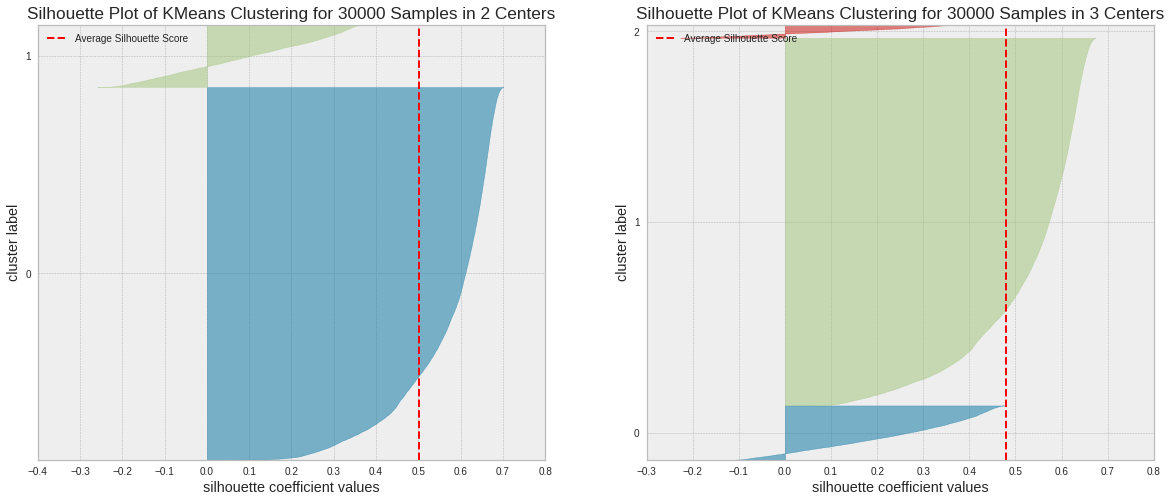

In [48]:

fig, ax = plt.subplots(1,2, figsize=(20,8))
visualizer = SilhouetteVisualizer(k_means_models["2"], colors='yellowbrick', ax=ax[0])
viz_2 = visualizer.fit(df_cluster)      
viz_2.finalize()
visualizer_ = SilhouetteVisualizer(k_means_models["3"], colors='yellowbrick', ax=ax[1])
viz_2 = visualizer_.fit(df_cluster)      
viz_2.finalize()

plt.savefig( ruta+"/plots/sihol_plot_2.png",bbox_inches='tight')
plt.show()

## Feature selection for each model (2 models)

In [20]:
df_prep["clusters"] = labels_kmeans["2"]
df_prep.drop("AGE", axis=1, inplace=True)

df_cluster_1 = df_prep[df_prep.clusters==0].drop("clusters", axis=1)

df_cluster_2 = df_prep[df_prep.clusters==1].drop("clusters", axis=1)

**Feature selection for model 1: Cluster 1**

In [25]:
X_1 = df_cluster_1.drop("default payment next month", axis=1)
y_1 = df_cluster_1[["default payment next month"]]

#------------------------------------------------------------------

mi_scores_1 = make_mi_scores(X_1, y_1)
mi_scores_1.head(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,MIC
REPAYS_MEAN,0.069832
PAY_0,0.069321
PAY_2,0.043392
PAY_3,0.033036
PAY_5,0.030275
PAY_4,0.028515
PAY_AMT_LAST_6M,0.027137
PAY_AMT_LAST_3M,0.026632
PAY_AMT1,0.026311
PAY_AMT_MAX,0.024703


In [24]:
var= list(mi_scores_1.iloc[0:15,:].index)
scores = list(mi_scores_1.iloc[0:15,:].MIC.values)

fig = go.Figure()
fig.add_trace(go.Bar(
    y= var,
    x= scores,
    orientation='h',
    marker=dict(
        color="cadetblue", opacity=0.5
        
    )))
fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='MIC')
fig.update_yaxes(title_text='Varibale')

fig['layout'].update(showlegend=True, title='Mutual information score for 15 variables in cluster 1', bargap=0.05)
iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

plotly.offline.plot(fig, filename = ruta+"/plots/mic_cluster_1.html", auto_open=False)

'/content/drive/MyDrive/prueba_addi//plots/mic_cluster_1.html'

Now to determine the number of variables to leave we are going to train a simple model like Logistic Regression varying the number of variables

In [26]:
solver = "liblinear"
penalty = "l1"
C=0.1
class_weight="balanced"

In [ ]:
X_1 = X_1[list(mi_scores_1.index)]
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, shuffle=True, stratify=y_1, random_state=0, test_size=0.2)

scores, importance = select_k_variables(mi_scores_1, X_train, y_train, X_test, y_test, solver, penalty, C, class_weight )[0], select_k_variables(mi_scores_1, X_train, y_train, X_test, y_test, solver, penalty, C, class_weight )[1]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConv

In [24]:
max_value = max(scores)
max_index = scores.index(max_value) 
X_1.drop(importance[:max_index], axis=1, inplace=True)

print("Number of feautures to drop:", max_index)

Number of feautures to drop: 1


In [24]:
X_1.to_csv( ruta+"/data/cluster_1_clean.csv", index=False)

**Features selection for cluster 2**

In [25]:
X_2 = df_cluster_2.drop("default payment next month", axis=1)
y_2 = df_cluster_2[["default payment next month"]]

mi_scores_2 = make_mi_scores(X_2, y_2)
mi_scores_2.head(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,MIC
PAY_0,0.097838
REPAYS_MEAN,0.094927
PAY_2,0.061335
PAY_3,0.051328
PAY_4,0.036379
PAY_5,0.032980
BILL_AMT/PAY_AMT_1,0.032018
PAY_AMT1,0.027080
BILL_AMT/PAY_AMT_4,0.024711
BILL_AMT/PAY_AMT_5,0.023044


In [25]:
var= list(mi_scores_2.iloc[0:15,:].index)
scores = list(mi_scores_2.iloc[0:15,:].MIC.values)

fig = go.Figure()
fig.add_trace(go.Bar(
    y= var,
    x= scores,
    orientation='h',
    marker=dict(
        color="cadetblue",opacity=0.5
        
    )))
fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='MIC')
fig.update_yaxes(title_text='Varibale')

fig['layout'].update(showlegend=True, title='Mutual information score for 15 variables in cluster 2', bargap=0.05)
iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

plotly.offline.plot(fig, filename = ruta+"/plots/mic_cluster_2.html", auto_open=False)

'/content/drive/MyDrive/prueba_addi//plots/mic_cluster_2.html'

In [26]:
X_2 = X_2[list(mi_scores_2.index)]
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, shuffle=True, stratify=y_2, random_state=0, test_size=0.2)


scores, importance = select_k_variables(mi_scores_2, X_train, y_train, X_test, y_test, solver, penalty, C, class_weight )[0], select_k_variables(mi_scores_2, X_train, y_train, X_test, y_test, solver, penalty, C, class_weight )[1]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConv

In [27]:
max_value = max(scores)
max_index = scores.index(max_value) 
X_2.drop(importance[:max_index], axis=1, inplace=True)

print("Number of feautures to drop:", max_index)

Number of feautures to drop: 48


In [115]:
X_2.to_csv( ruta+"/data/cluster_2_clean.csv", index=False)

## Modeling

**SMOTE TOMEK: CREATING A BALANCED DATASET**

In [32]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, shuffle=True, stratify=y_1, random_state=0, test_size=0.3)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, shuffle=True, stratify=y_2, random_state=0, test_size=0.2)

In [33]:
print("Dimension before resample for cluster 1:", X_train_1.shape,)
print("Dimension before resample for cluster 2:", X_train_2.shape)

Dimension before resample for cluster 1: (18011, 74)
Dimension before resample for cluster 2: (3415, 38)


In [34]:
##Fit SMOTE TOMEK  for each cluster of clients

resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

X_train_1, y_train_1 = resample.fit_resample(X_train_1, y_train_1)


X_train_2, y_train_2 = resample.fit_resample(X_train_2, y_train_2)

print("Dimension after resample for cluster 1:", X_train_1.shape,)
print("Dimension after resample for cluster 2:", X_train_2.shape)

Dimension after resample for cluster 1: (27680, 74)
Dimension after resample for cluster 2: (5490, 38)


**Baseline models**

In [35]:
models = [ SVC(probability=True), KNeighborsClassifier(n_neighbors=6), XGBClassifier(), GaussianNB()]
models_text = [ "SVC", "KNN", "XGB", "GNB"]

**Training algorithms for cluster 1**

In [1]:
f1_scores_1, acuraccy_scores_1,  auc_scores_1,  models_fit_1 =train_baseline_models( models, X_train_1.values, y_train_1.values, n_splits_=10, n_rep=3)

NameError: ignored

In [43]:
y_train_1

,default payment next month
0,1
1,0
2,0
3,0
4,1
...,...
27675,1
27676,1
27677,1
27678,1
